<h1> Realistic Botnet Traffic Generation using GANs </h1><br>
Rizwan Hamid Randhawa<br>
Development Notebook
<hr>

This notebook is for a conference publication <hr>


<a id="TOC"></a><h2>Table of Contents</h2>
<br>
<a href='#Setup'> Setup</a><br>
<br>
<a href='#EDA'> Preprocessing </a><br>
<a href='#xgboost botnet detection'> Botnet Detection</a><br>
<a href='#Classification'> Subclass clustering </a><br>
<br>
<a href="#GAN setup"> GAN setup and training</a><br>
<br>
<a href="#Compare GAN Output"> Compare GAN Output</a><br>
<a href="#Generated Data Testing"> Generated Data Testing</a><br>
<a href="#Summary"> Summary of Training Data</a><br>
<br>


<a id="Setup"><h1>Setup</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>

- Load libraries
- Load common functions
- Load stored datasets
- Use linux for xgboost and tensorflow

In [1]:
# !conda install tensorflow

In [2]:
MAIN_CODE_PATH = '/home/riz/Insync/rhr407@gmail.com/Google Drive - Shared with me/PhD/Development/codes/code-in-prog/project-folder/'
DATA_SET_PATH = '/home/riz/Insync/rhr407@gmail.com/Google Drive - Shared with me/PhD/Development/codes/code-in-prog/Data_set/'

In [3]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

   
import numpy as np
import pandas as pd

from scipy import stats



# from tensorflow.keras import backend
from tensorflow.python.keras import backend


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb

import pickle

import gc
gc.collect()


# Load custom functions

import gan

# For reloading after making changes
import importlib
importlib.reload(gan) 
from gan import *

import pandas as pd

import timeit
# code you want to evaluate




Using TensorFlow backend.


In [4]:
%cd $DATA_SET_PATH
!ls

/home/riz/Insync/rhr407@gmail.com/Google Drive - Shared with me/PhD/Development/codes/code-in-prog/Data_set
botnet.data.csv
botnet.testing_data.csv
check_data.csv
creditcard.csv
credit_card_data
data.csv
DATA.csv
Friday-WorkingHours.pcap_Flow.csv
Friday-WorkingHours.pcap_Flow.pkl
gen_data_set.csv
ISCX_Botnet-Testing.pcap_Flow.csv
ISCX_Botnet-Training.pcap_Flow.csv
ISCX_Botnet-Training-time-correction-done.pcap_Flow.csv
testing_data.csv
testing_DATA.csv


In [5]:
# Save engineered dataset for use in analysis
# Save as pickle for faster reload

data = pd.read_csv (r'data.csv', low_memory=False)
data= data.drop(['Unnamed: 0'], axis=1)

testing_data = pd.read_csv (r'testing_data.csv', low_memory=False)
testing_data= testing_data.drop(['Unnamed: 0'], axis=1)

<a id="botnet detection"><h1>Botnet Detection with Original Trian and Test Data</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>

- Here we'll use the xgboost algorithm to detect botnet flows

In [6]:
train_df = data.reset_index(drop=True)
test_df = testing_data.reset_index(drop=True)



y_true = train_df['Label'].values


print( 'train, test: ', len(train_df), len(test_df) )

accu_list = []    
rcl_list = []
prec_list = []

from sklearn.metrics import recall_score, precision_score, accuracy_score

train, test:  356156 309187


In [7]:
train_df = data.reset_index(drop=True)
test_df = testing_data.reset_index(drop=True)

In [8]:
print( 'train, test: ', len(train_df), len(test_df) )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

# with tf.device("/gpu:1"):
results_dict = {}

xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,     
                     feval = recall, maximize=True  
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_test = test_df['Label'].values   

train, test:  356156 309187


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [9]:
accu = accuracy_score(y_test, np.round(y_pred), normalize=True).round(2)
rcl = recall_score(y_test, np.round(y_pred)).round(2)
prec = precision_score(y_test, np.round(y_pred)).round(2)

accu_list.append(accu)
rcl_list.append(rcl)
prec_list.append(prec)

print( 'Accuracy: ' + str(accu) + str('%'))
print( 'Recall: ' + str(rcl) + str('%'))
print( 'Precision: ' + str(prec) + str('%'))

Accuracy: 0.38%
Recall: 0.43%
Precision: 0.47%


In [10]:
X_col = train_df.columns[:-1]
y_col = train_df.columns[-1]

X_train = train_df[X_col].values
y_train = train_df[y_col].values

X_test = test_df[X_col].values
y_test = test_df[y_col].values

def clsfr_train_test(clf):
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    accu = accuracy_score(y_test, np.round(y_pred), normalize=True).round(2)
    rcl = recall_score(y_test, np.round(y_pred)).round(2)
    prec = precision_score(y_test, np.round(y_pred)).round(2)
    
    accu_list.append(accu)
    rcl_list.append(rcl)
    prec_list.append(prec)

    
    print( 'Accuracy: ' + str( accu) )
    print( 'Recall: ' + str(rcl) )
    print( 'Precision: ' + str(prec) + '\n\n')

In [11]:
%%time
# with tf.device("/gpu:1"):
print('Running RF...')
clsfr_train_test(clf=RandomForestClassifier(n_estimators=100))

print('Running DT...')
clsfr_train_test(clf=DecisionTreeClassifier())

print('Running LR...')
clsfr_train_test(clf=LogisticRegression())

print('Running KNN...')
clsfr_train_test(clf=KNeighborsClassifier(n_neighbors=5))

# print('Running SVM...')
# clsfr_train_test(clf=SVC(kernel='linear'))

print('Running NB...')
clsfr_train_test(clf=GaussianNB())

print(accu_list)
print(rcl_list)
print(prec_list)


Running RF...
Accuracy: 0.42
Recall: 0.02
Precision: 0.64


Running DT...
Accuracy: 0.36
Recall: 0.31
Precision: 0.44


Running LR...


/home/riz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.59
Recall: 1.0
Precision: 0.59


Running KNN...


KeyboardInterrupt: 

ValueError: shape mismatch: objects cannot be broadcast to a single shape

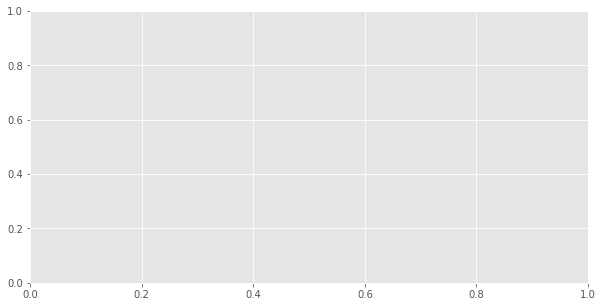

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# clfr_list =['XGB', 'RF', 'DT', 'LR', 'KNN', 'SVM', 'NB']
clfr_list =['XGB', 'RF', 'DT', 'LR', 'KNN', 'NB']


# Setting the positions and width for the bars
pos = list(range(len(clfr_list))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        accu_list, 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label the first value in first_name
        label='Accuracy') 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        rcl_list,
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F78F1E', 
        # with label the second value in first_name
        label='Recall') 

# Create a bar with post_score data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        #using df['post_score'] data,
        prec_list, 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#FFC222', 
        # with label the third value in first_name
        label='Precision') 

# Set the y axis label
ax.set_ylabel('Fraction')

# Set the chart's title
ax.set_title('Performance of Botnet Detectors on Original Train and Test Sets')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(clfr_list)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
# plt.ylim([0, max(df['pre_score'] + df['mid_score'] + df['post_score'])] )

# Adding the legend and showing the plot
plt.legend(['Accuracy', 'Recall', 'Precision'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
# import operator
# x = xgb_test.get_fscore()
# sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

# # print( 'Top eight features for botnet detection: ', [ i[0] for i in sorted_x[:8] ] )

# sorted_cols = [i[0] for i in sorted_x] + ['Label']
# print( sorted_cols )
# len(sorted_cols)

In [ ]:

# define the columns we want to test on, in case we want to use less than the full set

# testing_data = testing_data.drop(['Fwd IAT Min', 'Bwd IAT Mean', 'Active Std', 'Fwd Pkt Len Mean', 'Idle Min', 'RST Flag Cnt', 'Idle Max', 'Idle Std'])
print(testing_data.shape)
print(data.shape)

testing_data = testing_data[data.columns]

print(testing_data.shape)

X_train = data[:-1]
X_test = testing_data[:-1]

y_train = data['Label']
y_test = testing_data['Label']

In [ ]:
%%time

# Define some custom metric functions for use with the xgboost algorithm
# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py
# import tensorflow as tf

# with tf.device("/gpu:0"):
# from sklearn.metrics import recall_score, precision_score, roc_auc_score

# def recall(preds, dtrain):
#     labels = dtrain.get_label()
#     return 'recall',  recall_score(labels, np.round(preds))

# def precision(preds, dtrain):
#     labels = dtrain.get_label()
#     return 'precision',  precision_score(labels, np.round(preds))

# def roc_auc(preds, dtrain):
#     labels = dtrain.get_label()
#     return 'roc_auc',  roc_auc_score(labels, preds)

In [ ]:
accu_list = []    
rcl_list = []
prec_list = []

In [ ]:
import gan
import importlib
importlib.reload(gan) # For reloading after making changes
from gan import *


prefix = 'GAN'

CACHE_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-cache/GAN/'
FIGS_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/GAN/'

[combined_loss, disc_loss_generated, disc_loss_real, xgb_losses, svm_losses, dt_losses, nb_losses, knn_losses, rf_losses, lr_losses] = pickle.load(open(CACHE_PATH+prefix+'_losses_step_'+str(int(i))+'.pkl','rb'))

print(CACHE_PATH+prefix+'_losses_step_'+str(int(i))+'.pkl','rb')

best_xgb = xgb_losses.min()
# best_svm = xgboost_losses.min()
best_dt = dt_losses.min()
best_nb = nb_losses.min()
best_knn = knn_losses.min()
best_rf = rf_losses.min()
best_lr = lr_losses.min()

best_indices_list = [best_xgb, best_dt, best_nb, best_knn, best_rf, best_lr] 

for i in best_indices_list:

    ##################################################################


    seed = 0

    base_n_count = 128

    train = data.copy().reset_index(drop=True) # botnet only with labels from classification
    # train = data.loc[ data['Label']==1 ].copy()

    print(train.shape)
    # train = pd.get_dummies(train, columns=['Label'], prefix='Label', drop_first=True)
    label_cols = [ i for i in train.columns if 'Label' in i ]
    data_cols = [ i for i in train.columns if i not in label_cols ]

    train_no_label = train[ data_cols ]

    data_dim = len(data_cols)
    label_dim = len(label_cols)

    print(label_dim)
    with_class = False
    if label_dim > 0: with_class = True
    np.random.seed(seed)

    rand_dim = data.shape[1] 


    # define network models

    # generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='')
    # generator_model.load_weights(CACHE_PATH +'WGAN_generator_model_weights_step_2.h5')
    # generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
    # generator_model.load_weights('/home/rizwan/jupyter-cache/0002/CGAN_generator_model_weights_step_5000.h5')


    with_class = False
    train = train_no_label
    label_cols = []
    generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)

    # generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count, type='Wasserstein')
    generator_model.load_weights(CACHE_PATH +'GAN_generator_model_weights_step_' + str(i) + '.h5')


    ####################################################################
    # Now generate some new data

    test_size = 113680 # Equal to all of the botnet flows

    # x = get_data_batch(train, test_size, seed=17)
    x = get_data_batch(train, test_size, seed=0)
    z = np.random.normal(size=(test_size, rand_dim), scale =0.02)


    K.set_learning_phase(0)  # 0 = test
    g_z = generator_model.predict(z)


    g_z = pd.DataFrame(g_z, columns=data_cols+label_cols)
    g_z.loc[:, 'Label'] = 1

    # bots = data.loc[ data['Label']==1 ].copy()
    # gen_data_set = pd.concat([data, bots])
    
    gen_data_set = pd.concat([data, g_z])
    gen_data_set = gen_data_set.reset_index(drop=True)


    gen_benign_counts = gen_data_set['Label'].value_counts()[0]
    print(gen_benign_counts)

    train_df = gen_data_set.reset_index(drop=True)
    test_df = testing_data.reset_index(drop=True)

    print( 'train, test: ', len(train_df), len(test_df) )

    X_col = test_df.columns[:-1]
    y_col = test_df.columns[-1]
    dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)


    ###############################################################################
    # Run the xgboost algorithm, maximize recall on the test set
    import tensorflow as tf

    # with tf.device("/gpu:1"):
    results_dict = {}
# =============================================================================================
    # Run the xgboost algorithm, maximize recall on the test set


    print( 'train, test: ', len(train_df), len(test_df) )

    X_col = test_df.columns[:-1]
    y_col = test_df.columns[-1]
    dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

    # with tf.device("/gpu:1"):
    results_dict = {}

    xgb_params = {
        'max_depth': 4,
        'objective': 'binary:logistic',
        'random_state': 0,
        'eval_metric': 'auc', # auc, error
    #     'tree_method': 'hist'
    #     'grow_policy': 'lossguide' # depthwise, lossguide
    }

    xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                         verbose_eval=False,
                         early_stopping_rounds=20, 
                         evals=[(dtrain,'train'),(dtest,'test')],
                         evals_result = results_dict,     
                         feval = recall, maximize=True  
    #                      feval = roc_auc, maximize=True
                        )

    y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
    y_test = test_df['Label'].values 

In [ ]:
accu = accuracy_score(y_test, np.round(y_pred), normalize=True).round(2)
rcl = recall_score(y_test, np.round(y_pred)).round(2)
prec = precision_score(y_test, np.round(y_pred)).round(2)

accu_list.append(accu)
rcl_list.append(rcl)
prec_list.append(prec)

print( 'Accuracy: ' + str(accu) + str('%'))
print( 'Recall: ' + str(rcl) + str('%'))
print( 'Precision: ' + str(prec) + str('%'))

In [ ]:
X_col = train_df.columns[:-1]
y_col = train_df.columns[-1]

X_train = train_df[X_col].values
y_train = train_df[y_col].values

X_test = test_df[X_col].values
y_test = test_df[y_col].values

def clsfr_train_test(clf):
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    accu = accuracy_score(y_test, np.round(y_pred), normalize=True).round(2)
    rcl = recall_score(y_test, np.round(y_pred)).round(2)
    prec = precision_score(y_test, np.round(y_pred)).round(2)
    
    accu_list.append(accu)
    rcl_list.append(rcl)
    prec_list.append(prec)

    
    print( 'Accuracy: ' + str( accu) )
    print( 'Recall: ' + str(rcl) )
    print( 'Precision: ' + str(prec) + '\n\n')

In [ ]:
%%time
# with tf.device("/gpu:1"):
print('Running RF...')
clsfr_train_test(clf=RandomForestClassifier(n_estimators=100))

print('Running DT...')
clsfr_train_test(clf=DecisionTreeClassifier())

print('Running LR...')
clsfr_train_test(clf=LogisticRegression())

print('Running KNN...')
clsfr_train_test(clf=KNeighborsClassifier(n_neighbors=5))

# print('Running SVM...')
# clsfr_train_test(clf=SVC(kernel='linear'))

print('Running NB...')
clsfr_train_test(clf=GaussianNB())

print(accu_list)
print(rcl_list)
print(prec_list)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# clfr_list =['XGB', 'RF', 'DT', 'LR', 'KNN', 'SVM', 'NB']
clfr_list =['XGB', 'RF', 'DT', 'LR', 'KNN', 'NB']


# Setting the positions and width for the bars
pos = list(range(len(clfr_list))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        accu_list, 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label the first value in first_name
        label='Accuracy') 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        rcl_list,
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F78F1E', 
        # with label the second value in first_name
        label='Recall') 

# Create a bar with post_score data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        #using df['post_score'] data,
        prec_list, 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#FFC222', 
        # with label the third value in first_name
        label='Precision') 

# Set the y axis label
ax.set_ylabel('Fraction')

# Set the chart's title
ax.set_title('Performance of Botnet Detectors on Original Train and Test Sets')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(clfr_list)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
# plt.ylim([0, max(df['pre_score'] + df['mid_score'] + df['post_score'])] )

# Adding the legend and showing the plot
plt.legend(['Accuracy', 'Recall', 'Precision'], loc='upper left')
plt.grid()
plt.show()